<a href="https://colab.research.google.com/github/AndreiMoraru123/Optimization/blob/main/InteriorPointsMethod.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Let's explore another optimization problem, but this time with an inequality constraint. The way we can achieve this is by modifying our original function in order to make it embedd both the constraint, and a penalizing function of said constaint. One common method used to do this is adding a **logarithmic barrier** to the objective function

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import sympy as sym
import warnings
from IPython.display import display, Math, Latex
warnings.filterwarnings("ignore")

We define our function and impose a constaint:

In [2]:
def fcn(x, y):
    x, y = np.meshgrid(x, y)
    z = (x + 5)**2 + (y + 12)**2
    return z


x = np.linspace(-80, 80, 201)
y = np.linspace(-80, 80, 201)

Z = fcn(x, y)

def constraint(x,y):
    x, y = np.meshgrid(x, y)
    c = 5 * x - 6 * y + 230
    return c

C = constraint(x, y)

Let's visualize graphically what we want to do. Since we want this constraint to be smaller than or equal to zero (0) , we would like our solution to be in the left side of the zone above the yellow line. This means that the constaint minimum will not be the actual global minimum. If we wanted the constraint to be greater than or equal to zero (0), then we would have to look for the minimum in the right side of the region.

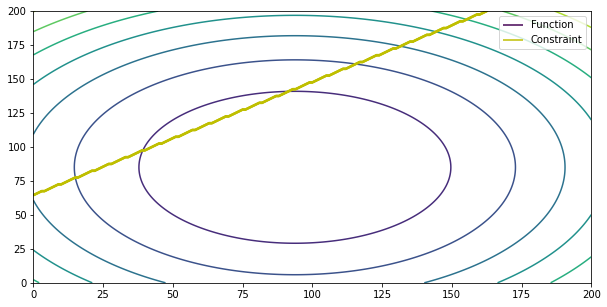

In [5]:
fig, ax = plt.subplots(figsize = (10,5))

cntr1 = ax.contour(Z)
cntr2 = ax.contour(C <=0, colors = 'y')
h1,_ = cntr1.legend_elements()
h2,_ = cntr2.legend_elements()
ax.legend([h1[0], h2[0]], ['Function', 'Constraint'])
plt.show()

Sympy will be used for symbolic computation, in this way this code can be tested for any function and any constaint, as the first and second order derivatives will be calculated by Python for us.

In [6]:
sx, sy = sym.symbols('x,y')

sZ = (sx + 5)**2 + (sy + 12)**2
sC =  5 * sx - 6 * sy + 230

df_x = sym.lambdify((sx, sy), sym.diff(sZ, sx), 'sympy')
df_y = sym.lambdify((sx, sy), sym.diff(sZ, sy), 'sympy')

print('Objective Function:')
display(sZ)

print('First Order Derivatives:')
display(sym.diff(sZ, sx))
display(sym.diff(sZ, sy))


Objective Function:


(x + 5)**2 + (y + 12)**2

First Order Derivatives:


2*x + 10

2*y + 24

In [7]:
hess = sym.lambdify((sx,sy), sym.hessian(sZ, [sx,sy]), 'sympy')
display(sym.hessian(sZ, [sx,sy]))

Matrix([
[2, 0],
[0, 2]])

Besides the visual reprezentation, we can confirm this function has a minimum (so it makes sense to try to minimize it) by taking a look at the eigenvalues of the Hessian. AS they are positive, that makes our Hessian matrix positive definite, which means that the slope from that point onwards goes up, therefore our point can only be a (local) minimum

In [8]:
SymHess = sym.hessian(sZ, [sx,sy])
SymHess.eigenvals()

{2: 2}

Now we do the same thing for our constaint:

In [9]:
dc_x = sym.lambdify((sx, sy), sym.diff(sC, sx), 'sympy')
dc_y = sym.lambdify((sx, sy), sym.diff(sC, sy), 'sympy')

print('Constraint:')
display(sC)

print('First Order Derivatives:')
display(sym.diff(sC, sx))
display(sym.diff(sC, sy))

Constraint:


5*x - 6*y + 230

First Order Derivatives:


5

-6

We define our new objective function, with the logarithmic barrier added:

In [10]:
def new_f(t,x,y):
    x, y = np.meshgrid(x, y)
    phi = (x + 5)**2 + (y + 12)**2 + 1/t * -np.log(- (5 * x - 6 * y + 230) )
    return phi

t = 0.1

x = np.linspace(-80, 80, 201)
y = np.linspace(-80, 80, 201)

Phi = new_f(t,x,y)

In [11]:
st = sym.symbols('t')

newZ = (sx + 5)**2 + (sy + 12)**2 + (1/st) * -sym.log(- (5 * sx - 6 * sy + 230) )

dnewf_x = sym.lambdify((sx, sy, st), sym.diff(sZ, sx), 'sympy')
dnewf_y = sym.lambdify((sx, sy, st), sym.diff(sZ, sy), 'sympy')

print('New Objective Function:')
display(newZ)

print('New First Order Derivatives:')
display(sym.diff(newZ, sx))
display(sym.diff(newZ, sy))

New Objective Function:


(x + 5)**2 + (y + 12)**2 - log(-5*x + 6*y - 230)/t

New First Order Derivatives:


2*x + 10 + 5/(t*(-5*x + 6*y - 230))

2*y + 24 - 6/(t*(-5*x + 6*y - 230))

In [12]:
newHess = sym.lambdify((sx,sy,st), sym.hessian(newZ, [sx,sy]), 'sympy')
display(sym.hessian(newZ, [sx,sy]))

Matrix([
[2 + 25/(t*(-5*x + 6*y - 230)**2),    -30/(t*(-5*x + 6*y - 230)**2)],
[   -30/(t*(-5*x + 6*y - 230)**2), 2 + 36/(t*(-5*x + 6*y - 230)**2)]])

Let's take a look at our feasible set. As stated above, we are interested in the above (yellow region) when looking for the minimum

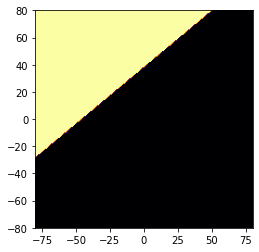

In [13]:
def plot_feasible_set(x, y):
    c = lambda xx, yy : 5*xx - 6*yy + 230
    plt.imshow(
        (c(x,y)<=0).astype(int),
        extent=(x.min(),x.max(),y.min(),y.max()),
        origin='lower',
        cmap='inferno')
    
x, y = np.meshgrid(x, y)
plot_feasible_set(x,y)

Now we can apply vanilla Newton's method on our new function, while updating t after each iteration using the following formula:

In [25]:
display(Math('t = (1 + 1/(13 * np.sqrt(nu))) * t'))

<IPython.core.display.Math object>

Our new stopping condition will again depend on t, and will look like this:

In [27]:
display(Math('m / t < tolerance'))

<IPython.core.display.Math object>

Where m is a hyperparameter you can play around with

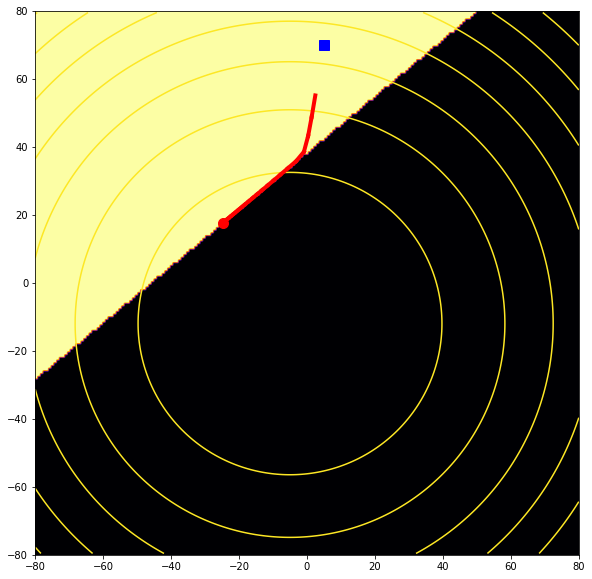

In [14]:
plt.figure(figsize = (10,10))
plt.contour(Z, extent=[x[0], x[-1], y[0], y[-1]], vmin=-1000, vmax=1000, origin='lower')

X = np.linspace(-80, 80, 201)
Y = np.linspace(-80, 80, 201)
X, Y = np.meshgrid(X, Y)
plot_feasible_set(X, Y)

t = .01
nu = 0.01

localmin = np.array([5,70])
statpnt = localmin[:]

m = 2
e = 1e-4

slow = .1
training_limit = 1000

i = 0;

trajectory = np.zeros((training_limit, 2))

while m / t > e:
    
    grad = np.array([dnewf_x(localmin.item(0), localmin.item(1), t),
                     dnewf_y(localmin.item(0), localmin.item(1), t)
                     ])
    Hess = np.array(newHess(localmin.item(0), localmin.item(1), t))
    
    t = (1 + 1/(13 * np.sqrt(nu))) * t
    
    Hss = np.vstack(Hess[:]).astype(np.float)
    invHess = np.linalg.inv(Hss)

    localmin = localmin - slow * np.matmul(invHess, grad)
    trajectory[i, :] = localmin
    
    if i > 1:
        plt.plot([trajectory[i-1, 0], localmin[0]], [trajectory[i-1, 1], localmin[1]], 'r', linewidth = 4)
    
    i += 1
       
plt.plot(statpnt[0], statpnt[1], 'bs', markersize = 10)
plt.plot(localmin[0], localmin[1], 'ro', markersize = 10)
plt.show()

Keep in mind we no longer started at a random point. For the Interior Points method to converge to the feasible set, we need to start at a location that is already inside the set.

If we start at a point that is outside of the yellow region, the algorithm will just converge to the local (global in our case) usual minimum that it would find. 

I use a variable to slow down the algortihm to get a better visualization of the trajectory, otherwise Newton will converge in one step, as this function is quadratic.

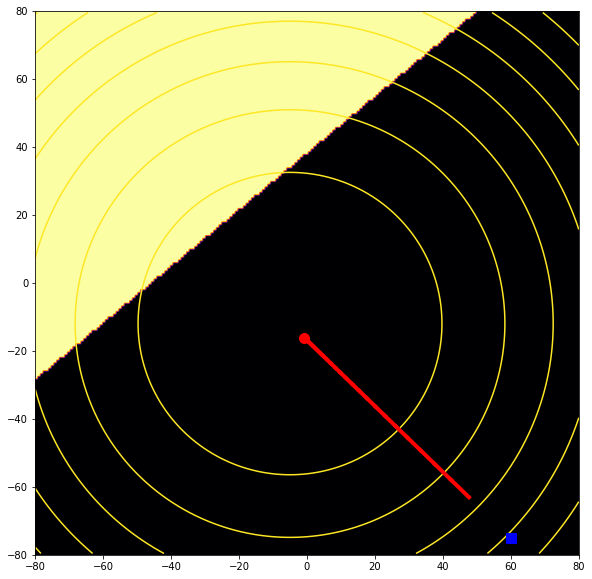

In [15]:
plt.figure(figsize = (10,10))
plt.contour(Z, extent=[x[0], x[-1], y[0], y[-1]], vmin=-1000, vmax=1000, origin='lower')

X = np.linspace(-80, 80, 201)
Y = np.linspace(-80, 80, 201)
X, Y = np.meshgrid(X, Y)
plot_feasible_set(X, Y)

t = .01
nu = 0.01

localmin = np.array([60,-75])
statpnt = localmin[:]

m = 2
e = 1e-4

slow = .1
training_limit = 1000

i = 0;

trajectory = np.zeros((training_limit, 2))

while m / t > e:
    
    grad = np.array([dnewf_x(localmin.item(0), localmin.item(1), t),
                     dnewf_y(localmin.item(0), localmin.item(1), t)
                     ])
    Hess = np.array(newHess(localmin.item(0), localmin.item(1), t))
    
    t = (1 + 1/(13 * np.sqrt(nu))) * t
    
    Hss = np.vstack(Hess[:]).astype(np.float)
    invHess = np.linalg.inv(Hss)

    localmin = localmin - slow * np.matmul(invHess, grad)
    trajectory[i, :] = localmin
    
    if i > 1:
        plt.plot([trajectory[i-1, 0], localmin[0]], [trajectory[i-1, 1], localmin[1]], 'r', linewidth = 4)
    
    i += 1
       
plt.plot(statpnt[0], statpnt[1], 'bs', markersize = 10)
plt.plot(localmin[0], localmin[1], 'ro', markersize = 10)
plt.show()